In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import logomaker

import matplotlib.font_manager
plt.rcParams.update({'font.size': 18, 'font.weight':'normal'})
plt.rcParams.update({'font.family' : 'Arial','font.sans-serif':['Arial']})

Matplotlib is building the font cache; this may take a moment.


In [6]:
df_input = pd.read_csv('data/sgrna_seq.csv')
df_input

,sgrna,sgrna_seq,target_seq,extended_target_seq,LFC
0,chr1_196959066_196959088_-_2361,CATTGATTCTATTTTTCTTCAC,GTGAAGAAAAATAGAATCAATG,TATCCCAGTTGTGAAGAAAAATAGAATCAATGGCATTACTAT,-1.95270
1,chr1_196958980_196959002_-_2362,ATATCCAGATTTACAAACAAAT,ATTTGTTTGTAAATCTGGATAT,ACATAGTTGAATTTGTTTGTAAATCTGGATATCATCCAACAA,-1.88440
2,chr1_196949614_196949636_-_2363,TGTTGGTGACCATCCTTCTTCT,AGAAGAAGGATGGTCACCAACA,TAACGTGCGCAGAAGAAGGATGGTCACCAACACCAAAGTGTC,1.27680
3,chr1_196959107_196959129_-_2364,GTAAATTCAGAAAAAGGTGTGC,GCACACCTTTTTCTGAATTTAC,TTAGTAAAATGCACACCTTTTTCTGAATTTACTATTATATTT,1.27040
4,chr1_196957937_196957959_-_2365,CTGACAACAGGAATGAAGTAAT,ATTACTTCATTCCTGTTGTCAG,CAATGGAGACATTACTTCATTCCTGTTGTCAGTATATGCTCC,0.57566
...,...,...,...,...,...
395,chr14_37592731_37592753_+_10474,GAAGAAGCCCCGGAGGGCGGGG,CCCCGCCCTCCGGGGCTTCTTC,CCACCACTAACCCCGCCCTCCGGGGCTTCTTCACTCGCTGTC,1.69290
396,chr14_37594094_37594116_+_10475,TCCCTCTTCCCAAGATTATCCA,TGGATAATCTTGGGAAGAGGGA,GGAACTGCCTTGGATAATCTTGGGAAGAGGGAAAGAAAATAA,3.75330
397,chr14_37593671_37593693_+_10476,CTTAATTGAATGGTGGGGTCGA,TCGACCCCACCATTCAATTAAG,CGCAGTCATCTCGACCCCACCATTCAATTAAGACCCCTAGCG,-1.18000
398,chr14_37593235_37593257_+_10477,TTGTAGCAACTGTAATGTTAAA,TTTAACATTACAGTTGCTACAA,TTGCTTCCCTTTTAACATTACAGTTGCTACAAGCAGGTAGAA,-0.13608


## Generate Features

In [7]:
from scipy import stats
from scipy.special import expit
from Bio.SeqUtils import MeltingTemp as mt

base_encoder1 = {
  'A': [1, 0, 0, 0],
  'C': [0, 1, 0, 0],
  'G': [0, 0, 1, 0],
  'T': [0, 0, 0, 1]}

base_encoder2 = {
  'AA': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AC': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AG': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AT': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CA': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CC': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CG': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CT': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  'GA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  'GC': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  'GG': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  'GT': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'TA': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  'TC': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  'TG': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  'TT': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}



In [8]:
df_target_feature = pd.DataFrame()
for idx in df_input.index:
    target = df_input.loc[idx, 'extended_target_seq']
    target = target + 'N'*(33-len(target))
    ## 1. one-hot coding
    for k1, v1 in enumerate(target):
        lst_coding = base_encoder1[v1]
        df_target_feature.loc[idx, 'oht_'+str(k1)+'_A'] = lst_coding[0]
        df_target_feature.loc[idx, 'oht_'+str(k1)+'_C'] = lst_coding[1]
        df_target_feature.loc[idx, 'oht_'+str(k1)+'_G'] = lst_coding[2]
        df_target_feature.loc[idx, 'oht_'+str(k1)+'_T'] = lst_coding[3]
    ## 2. tm
    df_target_feature.loc[idx, 'Tm_target'] = mt.Tm_NN(target)
    df_target_feature.loc[idx, 'Tm_target_0_5'] = mt.Tm_NN(target[0:5])
    df_target_feature.loc[idx, 'Tm_target_5_10'] = mt.Tm_NN(target[5:10])
    df_target_feature.loc[idx, 'Tm_target_10_15'] = mt.Tm_NN(target[10:15])
    df_target_feature.loc[idx, 'Tm_target_15_22'] = mt.Tm_NN(target[15:])
    df_target_feature.loc[idx, 'Tm_target_0_10'] = mt.Tm_NN(target[0:10])
    df_target_feature.loc[idx, 'Tm_target_10_22'] = mt.Tm_NN(target[10:])
    ## 3. count
    df_target_feature.loc[idx, 'cnt_A_target'] = target.count('A')
    df_target_feature.loc[idx, 'cnt_C_target'] = target.count('C')
    df_target_feature.loc[idx, 'cnt_G_target'] = target.count('G')
    df_target_feature.loc[idx, 'cnt_T_target'] = target.count('T')
    df_target_feature.loc[idx, 'cnt_AA_target'] = target.count('AA')
    df_target_feature.loc[idx, 'cnt_AC_target'] = target.count('AC')
    df_target_feature.loc[idx, 'cnt_AG_target'] = target.count('AG')
    df_target_feature.loc[idx, 'cnt_AT_target'] = target.count('AT')
    df_target_feature.loc[idx, 'cnt_CA_target'] = target.count('CA')
    df_target_feature.loc[idx, 'cnt_CC_target'] = target.count('CC')
    df_target_feature.loc[idx, 'cnt_CG_target'] = target.count('CG')
    df_target_feature.loc[idx, 'cnt_CT_target'] = target.count('CT')
    df_target_feature.loc[idx, 'cnt_GA_target'] = target.count('GA')
    df_target_feature.loc[idx, 'cnt_GC_target'] = target.count('GC')
    df_target_feature.loc[idx, 'cnt_GG_target'] = target.count('GG')
    df_target_feature.loc[idx, 'cnt_GT_target'] = target.count('GT')
    df_target_feature.loc[idx, 'cnt_TA_target'] = target.count('TA')
    df_target_feature.loc[idx, 'cnt_TC_target'] = target.count('TC')
    df_target_feature.loc[idx, 'cnt_TG_target'] = target.count('TG')
    df_target_feature.loc[idx, 'cnt_TT_target'] = target.count('TT')
    
df_target_feature

,oht_0_A,oht_0_C,oht_0_G,oht_0_T,oht_1_A,oht_1_C,oht_1_G,oht_1_T,oht_2_A,oht_2_C,...,cnt_CG_target,cnt_CT_target,cnt_GA_target,cnt_GC_target,cnt_GG_target,cnt_GT_target,cnt_TA_target,cnt_TC_target,cnt_TG_target,cnt_TT_target
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,1.0,2.0,4.0,2.0,3.0,2.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,1.0,3.0,3.0,3.0,4.0,3.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,3.0,2.0,2.0,4.0,1.0,2.0,3.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,3.0,1.0,1.0,0.0,1.0,6.0,1.0,2.0,6.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3.0,6.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,2.0
396,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,3.0,6.0,1.0,4.0,0.0,2.0,1.0,3.0,2.0
397,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,2.0,2.0,2.0,0.0,1.0,2.0,4.0,0.0,2.0
398,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,1.0,3.0,1.0,2.0,4.0,1.0,2.0,6.0


## Lasso Model

In [9]:
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# functions to train lasso model
def train_lasso_model(x_pred,y_real,alpha=0.005,plot=False):
    clf_lin_r = linear_model.Lasso(alpha=alpha)
    clf_lin_r.fit(x_pred, y_real)
    
    y_pred=clf_lin_r.predict(x_pred)

    # test just on training data
#     fpr,tpr,_=roc_curve(y_real,y_pred)
#     roc_auc=auc(fpr,tpr)
#     print('train auc:'+str(roc_auc))
    if plot:
        plot_auc(fpr,tpr)
    
    return (clf_lin_r,y_pred)

import pandas as pd

# convert sequence features to pandas matrix
def get_seq_features(clf_lin,nt_for_feature):
    # 
    weight_mat=clf_lin.coef_[:nt_for_feature*4].reshape(nt_for_feature,4)
    
    weight_mat_p=pd.DataFrame(weight_mat)
    weight_mat_p=weight_mat_p.rename(columns={0:'A',1:'C',2:'G',3:'T'})
    return weight_mat_p

import seaborn as sns

def plot_weight_mat(weight_mat_p, roc_auc):
    plt.figure(figsize = (8,16))
    sns.heatmap(weight_mat_p, annot=True,cmap='bwr',center=0)
    plt.title(fname+' auc: %0.2f' % roc_auc)

# function definition
def plot_auc(false_positive,true_positive):
    from sklearn.metrics import roc_curve, auc
    roc_auc=auc(false_positive,true_positive)
    plt.figure(figsize=(8, 8))
    lw = 2
    plt.plot(false_positive, true_positive, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

/Users/xcheng/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03815236218637352, tolerance: 0.0078871875
  positive)
/Users/xcheng/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035683878169152194, tolerance: 0.007955000000000002
  positive)


test auc:0.8232323232323233
 


/Users/xcheng/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11387628821726281, tolerance: 0.009831000000000003
  positive)


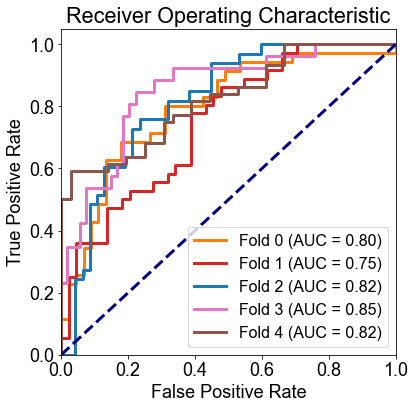

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

nt_for_feature = 42

lst_color = ['tab:orange', 'tab:red', 'tab:blue', 'tab:pink', 'tab:brown']

fea_m_pd = df_target_feature
fea_m_pd = fea_m_pd.fillna(0)
lst_indx = list(fea_m_pd.index)
lst_y = [1 if i < -0.5 else 0 for i in df_input.loc[lst_indx, 'LFC'].to_list()]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
df = pd.DataFrame(columns = ['sgrna', 'y', 'score'])

plt.figure(figsize=(6, 6))
lw = 3
num = 0
for train, test in kf.split(fea_m_pd):
    ##
    X_train = fea_m_pd.iloc[list(train),:]
    X_test = fea_m_pd.iloc[list(test),:]
    y_train = [lst_y[i] for i in train]
    y_test = [lst_y[i] for i in test]
    ##
    (clf_lin_r,y_pred)=train_lasso_model(X_train,y_train,plot=False)
    # specific guide predictor
    clf_lin_r_S=clf_lin_r
    y_pred_test=clf_lin_r.predict(X_test)
    for k in range(len(list(test))):
        df.loc[lst_indx[k], 'sgrna'] = lst_indx[k]
        df.loc[lst_indx[k], 'y'] = y_test[k]
        df.loc[lst_indx[k], 'score'] = y_pred_test[k]
    fpr,tpr,_=roc_curve(y_test,y_pred_test)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr, color=lst_color[num],
             lw=lw, label='Fold %d (AUC = %0.2f)' % (num, roc_auc))
    num = num +1
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=16)


##
fpr,tpr,_=roc_curve(df.y.to_list(),df.score.to_list())
roc_auc=auc(fpr,tpr)
print('test auc:'+str(roc_auc))
print(' ')

(clf_lin_r,y_pred)=train_lasso_model(fea_m_pd,lst_y,plot=False)


<Figure size 2880x432 with 0 Axes>

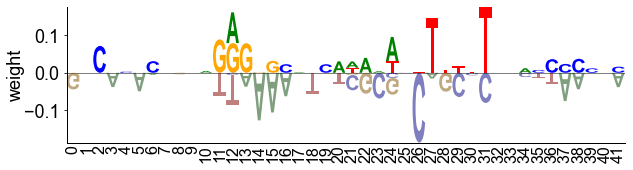

In [14]:
weight_mat_pd=get_seq_features(clf_lin_r, nt_for_feature)

df_lasso_weight_target_ext = weight_mat_pd.copy()

weight_mat_pd_tmp = weight_mat_pd.copy()

plt.figure(figsize=(40, 6))
# create Logo object
g = logomaker.Logo(weight_mat_pd_tmp,
                          shade_below=.5,
                          fade_below=.5)
# style using Logo methods
g.style_spines(visible=False)
g.style_spines(spines=['left', 'bottom'], visible=True)
g.style_xticks(rotation=90, fmt='%d', anchor=0, fontsize=16)
# style using Axes methods
g.ax.set_ylabel("weight", labelpad=-1)
g.ax.xaxis.set_ticks_position('none')
g.ax.xaxis.set_tick_params(pad=-1) 